Define priors, proprosal distribution, simulated dataset, euclidean distance


In [1]:
import random
random.seed(42)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def model(variables, t, params):
    m, p = variables.reshape((3, 2)).T
    k = params #a is fixed to 3, gamma to 0, n to 2

#b1=b2=b3=k3=0

    dm1dt = -m[0] + (10 ** 3 / (1 + (10 ** k[0] * p[1])**2)) + 1  
    dp1dt = -10 ** 0 * (p[0] - m[0])

    dm2dt = -m[1] + (10 ** 3 / ((1 + 10 ** k[1] * p[2])**2)) + 1  
    dp2dt = -10 ** 0 * (p[1] - m[1])

    dm3dt = -m[2] + (10 ** 3 / (1 + 10 ** k[2] * p[0])**2) + 1  
    dp3dt = -10 ** 0 * (p[2] - m[2])

    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]).flatten()

true_params = np.array([
1,1,1
]) #k1, k2,k3=1

def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,10), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

In [2]:
true_data = solve_ode(true_params)
def get_distance(truth, simulation):
    mean_squared_difference = np.mean(np.square(truth - simulation))
    return mean_squared_difference #OG distance function, bcz doing ratios same as sum of squared dist

In [3]:
from scipy.stats import norm
from math import prod
from scipy.stats import uniform

In [4]:
def gaussian_kernel(sd):
    gk=np.random.normal(0,sd,size=len(true_params)) #using symmetrical kernels for now
    return(gk) #need to take care in future in not generating negative values! (maybe a distribution that can only have pos values, look at lucias code ig)

In [5]:
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

In [7]:
sampled_params = uniform.rvs(-3,3,size=3)
s1=solve_ode(sampled_params) #no oscilattory behaviours???
print(s1)
sampled_data_s1 = solve_ode(sampled_params+gaussian_kernel(0.2))
euclidean_distance_multiple_trajectories(sampled_data_s1, true_data)

[[  0.           2.           0.           1.           0.
    3.        ]
 [ 47.03199745  21.31805553   8.29014479  23.19514102  19.85576365
   34.16684362]
 [  3.34317301   2.9371066   43.14315798 114.2202208   55.76753802
   35.99784346]
 [  2.62541312   7.89146848 292.01016659 336.98380326   7.17233881
    3.71740649]
 [ 15.63514106  48.93233858 320.7389727  228.43973072   1.24376274
    1.45463331]
 [144.01995643 193.1143828   74.91688792  39.40732072   1.64644433
    4.25279553]
 [141.71756565  68.37893069   7.71458542  13.02021498   9.24808514
   22.82726514]
 [  6.50204145   3.9146066   22.39902803  70.16742525  58.26364022
   48.68426472]
 [  2.11693204   5.02705229 195.77211002 287.15420908  15.3757085
    7.58728636]
 [  8.6462751   29.82700257 368.03133168 290.14059858   1.52094899
    1.41242517]]


283.4731629308288

In [253]:
def mcmc_abc(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr=np.zeros(num_iterations+1)
    #accepted_data = np.zeros((num_iterations + 1, len(true_data)))
    count = 0
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    distance= euclidean_distance_multiple_trajectories(true_data, sampled_data)
    for i in range(1, num_iterations + 1):
        if i % 1000 == 0:
            print(f"{i}th iterations done")
        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(0.5) #maybe this is giving parameters that are out of bounds?
        new_sampled_params = sampled_params+perturbation #clipping to ensure stays within bounds
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            pass #do not accept parameters if out of bounds of prior
        # Generate synthetic data using samples
        else:
            new_sampled_data = solve_ode(new_sampled_params)
            new_distance =  euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
            prob = min(1, distance/new_distance) 
            #if new distance is smaller than old, defo accept, 
            #else prob proportional to old_distance/new_distance
            distance_arr[i]=new_distance
            if prob > np.random.uniform(0, 1):
                count += 1
                #accepted_data[i] = sampled_data
                #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params
                distance=new_distance
            accepted_params[i] = sampled_params
        

    return accepted_params, count, distance_arr

In [6]:
def run_mult_chain(algorithm, chain,true_params, num_iterations):
    #algorithm=mcmc_abc or mcmc_abc_s1 scheme1
    chain_accepted_parameters=[]
    counts=[]
    dists=[]
    for i in range(chain):
        accepted_parameters, count, dist = algorithm(true_params, num_iterations)
        chain_accepted_parameters.append(accepted_parameters)
        counts.append(count)
        dists.append(dist)
        print(f"{i+1}th chain done")
    return(chain_accepted_parameters, counts, dists)



Potentialo method for decreasing the threshold: set first and final, every threshold decrease is 1/2 between previous and final

In [7]:
def mcmc_abc_s1(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr=np.zeros(num_iterations+1)
    count_arr = []
    count=0
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    threshold=300 #initial threshold
    target_thres=15
    distance=euclidean_distance_multiple_trajectories(true_data, sampled_data)
    for i in range(1, num_iterations + 1):
        if i % 2000 == 0:
            count_arr.append(count)
            count=0 #reset count
            if i+2000==num_iterations:
                threshold=target_thres #for final iteration use target threshold
            else:
                threshold=(threshold+target_thres)*0.5
            #decreasingf threshold every 1000 iterations
            #arbitrary at the moment
            #only look at the last 1000 samples for now
            print(f"{i}th iterations done, changing threshold to {threshold}")
        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(0.8) #maybe this is giving parameters that are out of bounds?
        new_sampled_params=sampled_params+perturbation
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            while max(new_sampled_params)>3 or min(new_sampled_params)<-3:
                perturbation = gaussian_kernel(0.8) #perturb again
                new_sampled_params=sampled_params+perturbation 
    # Generate synthetic data using samples
        new_sampled_data = solve_ode(new_sampled_params)
        distance = euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
        if distance < threshold: #if accepted next distance has to be 0.9 of that
            #prob = min(1, distance/new_distance)
            #if prob > np.random.uniform(0, 1):
            count += 1
            #accepted_data[i] = sampled_data
            #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
            sampled_params = new_sampled_params
        accepted_params[i] = sampled_params 
        distance_arr[i]=distance
                
        
        

    return accepted_params, count_arr, distance_arr

In [7]:
rng = np.random.default_rng()
def multivariate_gaussian_kernel(cov_params,scale=1):
    gk=scale*rng.multivariate_normal(mean=np.zeros(len(true_params)),cov=cov_params) #using symmetrical kernels for now
    return(gk)
 #need to take care in future in not generating negative values! (maybe a distribution that can only have pos values, look at lucias code ig)

Question: should i adapt the kernel size say every 1000 rounds? Or should it be some sort of trigger?
Adaptive kernel size - a lot of literature on this, easiest one just seems to be double the kernel if acceptance is above some arbitrary threshold, half if acceptance rate is below half of that threshold?


In [8]:
init_cov=[[1,0,0],[0,1,0],[0,0,1]]

In [9]:
def mcmc_abc_s2(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr= np.zeros(num_iterations+1)
    count_arr = []
    count=0
    cov=init_cov
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    threshold=300 #initial threshold
    distance=euclidean_distance_multiple_trajectories(true_data, sampled_data)
    for i in range(1, num_iterations + 1):
        if i % 1000 == 0:
            count_arr.append(count)
            count=0 #reset count
            dis_seg=distance_arr[i-1000:i]
            threshold=np.median(dis_seg[np.nonzero(dis_seg)]) #new threshold median of previous round
            if i/1000>1: #adaptive kernel sizes from 2000th iteration onwards
                cov=np.cov(accepted_params[1000:i,:],rowvar=False) #get covariance matrix of accepted parameters, after 1000 burnins
                print(cov)
            #decreasingf threshold every 1000 iterations
            #arbitrary at the moment
            #only look at the last 1000 samples for now
            print(f"{i}th iterations done, changing threshold to {threshold}")
        # Using Gaussian kernel to sample for next model parameters
        perturbation=multivariate_gaussian_kernel(cov)
        new_sampled_params=sampled_params+perturbation
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            while max(new_sampled_params)>3 or min(new_sampled_params)<-3:
                perturbation = multivariate_gaussian_kernel(cov) #perturb again
                new_sampled_params=sampled_params+perturbation 
    # Generate synthetic data using samples
        new_sampled_data = solve_ode(new_sampled_params)
        distance = euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
        if distance < threshold: #if accepted next distance has to be 0.9 of that
            #prob = min(1, distance/new_distance)
            #if prob > np.random.uniform(0, 1):
            count += 1
            #accepted_data[i] = sampled_data
            #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
            sampled_params = new_sampled_params 
            distance_arr[i]=distance
        accepted_params[i] = sampled_params
                

    return accepted_params, count_arr, distance_arr

In [44]:
print(count)

NameError: name 'count' is not defined

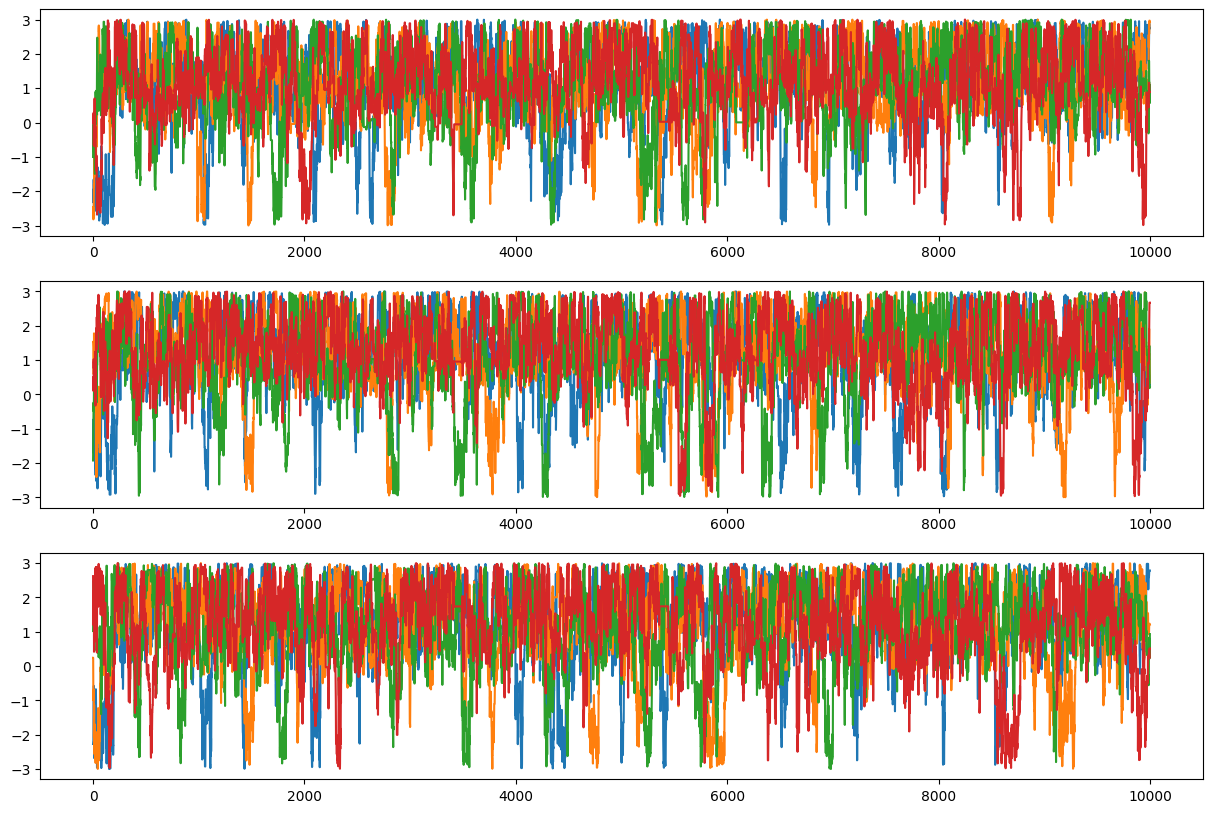

In [302]:
fig, axs = plt.subplots(3,1,figsize=(15, 10))
axs = axs.ravel()
for i in range(len(true_params)):
   for j in range(len(pa)):
      axs[i].plot(pa[j][:,i]) #each param, plot the results from chain
      


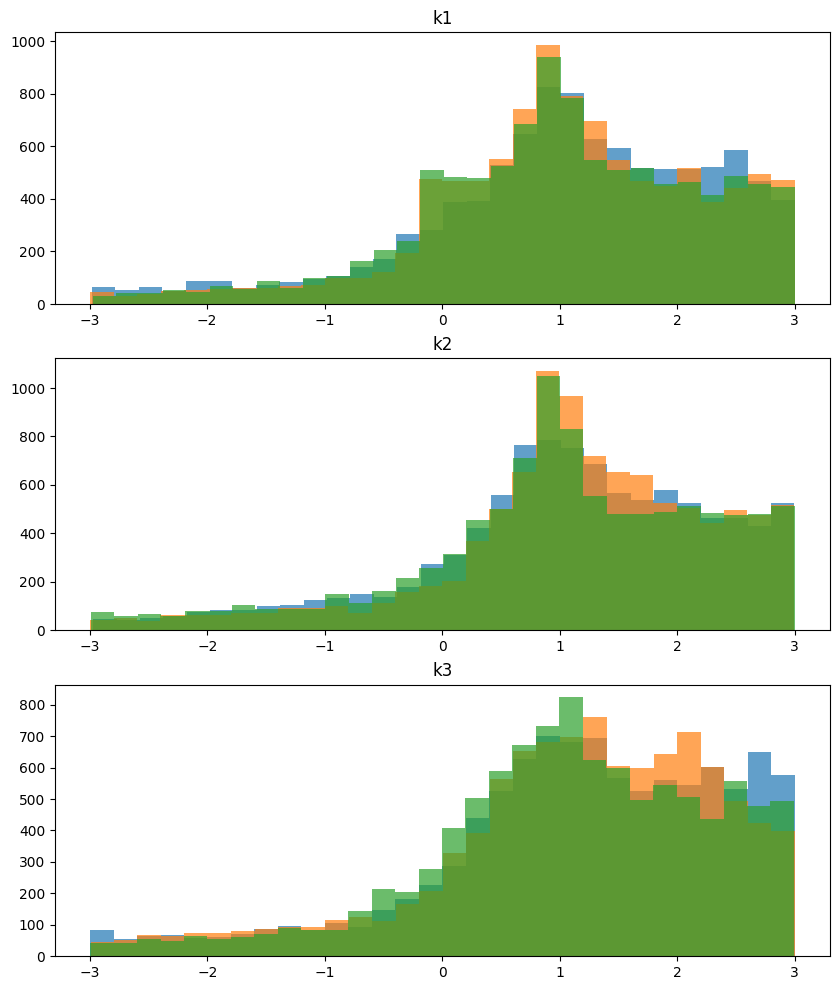

In [490]:
labels=["k1","k2","k3"]
fig, axs = plt.subplots(3,1,figsize=(10, 12))
axs = axs.ravel()
for p in range(0,3):
    for i in range(0,3):
        axs[p].hist(pa[i][:,p][0:], alpha=.7, bins=30)
    axs[p].set_title(labels[p])

In [10]:
pa1,count1, dist=run_mult_chain(mcmc_abc_s2,3,true_params,5000)

1000th iterations done, changing threshold to 43.53559886691167
[[0.70828152 0.20790421 0.21188982]
 [0.20790421 0.60493234 0.20456597]
 [0.21188982 0.20456597 0.68129964]]
2000th iterations done, changing threshold to 6.884667427265553
[[0.61638459 0.1947472  0.19783284]
 [0.1947472  0.56107173 0.22689966]
 [0.19783284 0.22689966 0.61305592]]
3000th iterations done, changing threshold to 3.159566808454803
[[0.52104604 0.15804061 0.15168526]
 [0.15804061 0.46349891 0.17535935]
 [0.15168526 0.17535935 0.51687561]]
4000th iterations done, changing threshold to 2.7870662619966047
[[0.43343363 0.12348938 0.11111551]
 [0.12348938 0.42926578 0.12709322]
 [0.11111551 0.12709322 0.43783943]]
5000th iterations done, changing threshold to 2.462277700218423
1th chain done
1000th iterations done, changing threshold to 48.82826141466548
[[0.73448829 0.22253757 0.35753041]
 [0.22253757 0.82559151 0.31318362]
 [0.35753041 0.31318362 0.90175354]]
2000th iterations done, changing threshold to 5.3952323

Text(0.5, 1.0, 'Distances with adaptive threshold sizes')

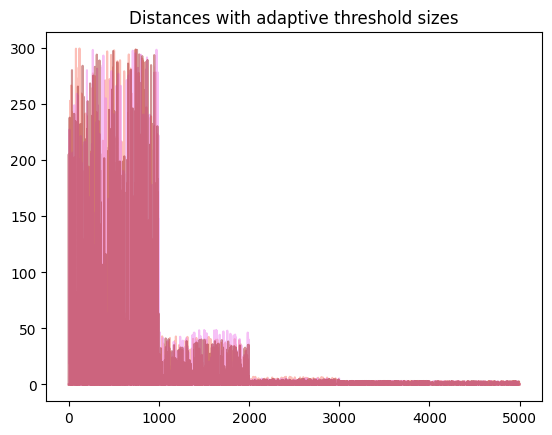

In [11]:
col=["salmon","violet","brown"]
for i in range(len(dist)):
    plt.plot(dist[i],color=col[i],alpha=0.5)
plt.title("Distances with adaptive threshold sizes")

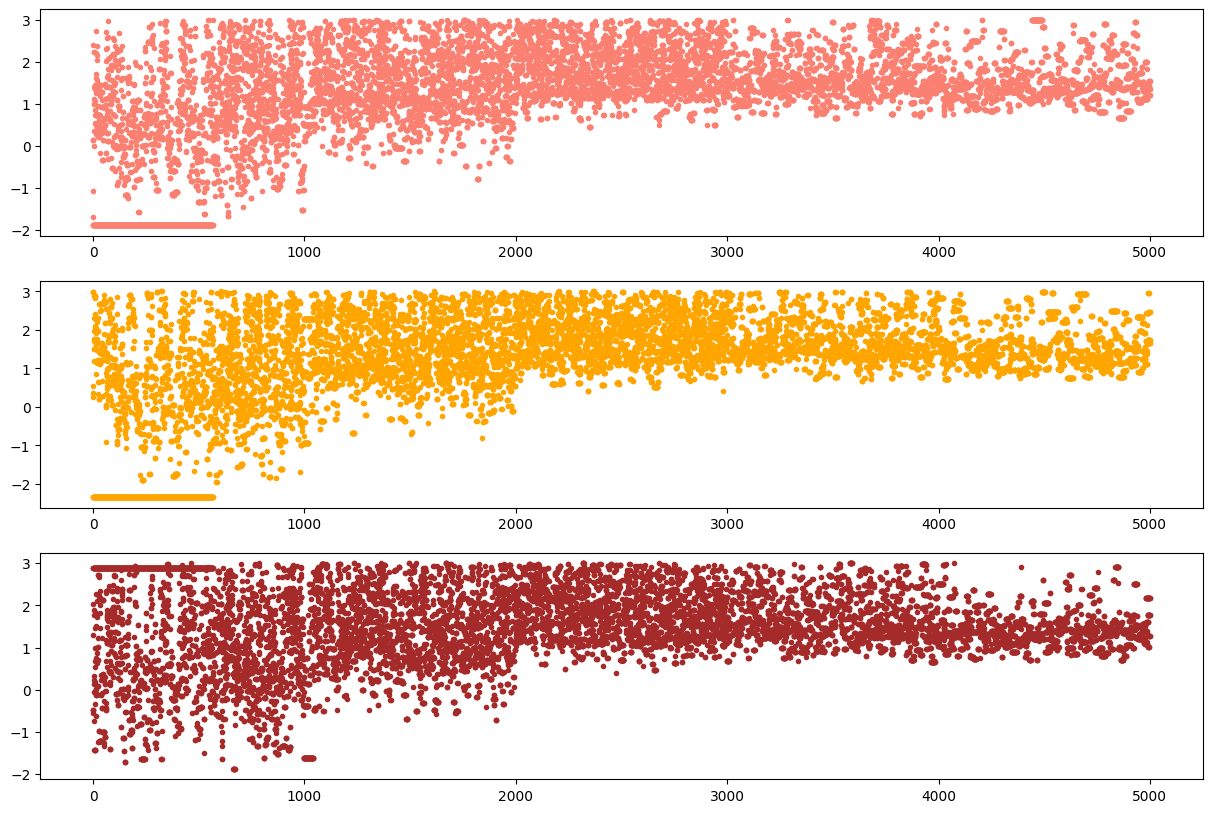

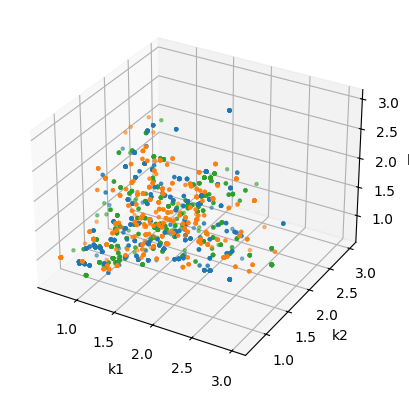

In [29]:
fig, axs = plt.subplots(3,1,figsize=(15, 10))
col=["salmon","orange","brown"]
axs = axs.ravel()
for i in range(len(true_params)):
   for j in range(len(pa1)):
      array=pa1[j][:,i] #jth chain
      axs[i].plot(array,marker='.',linestyle='',color=col[i]) #each param, plot the results from chain




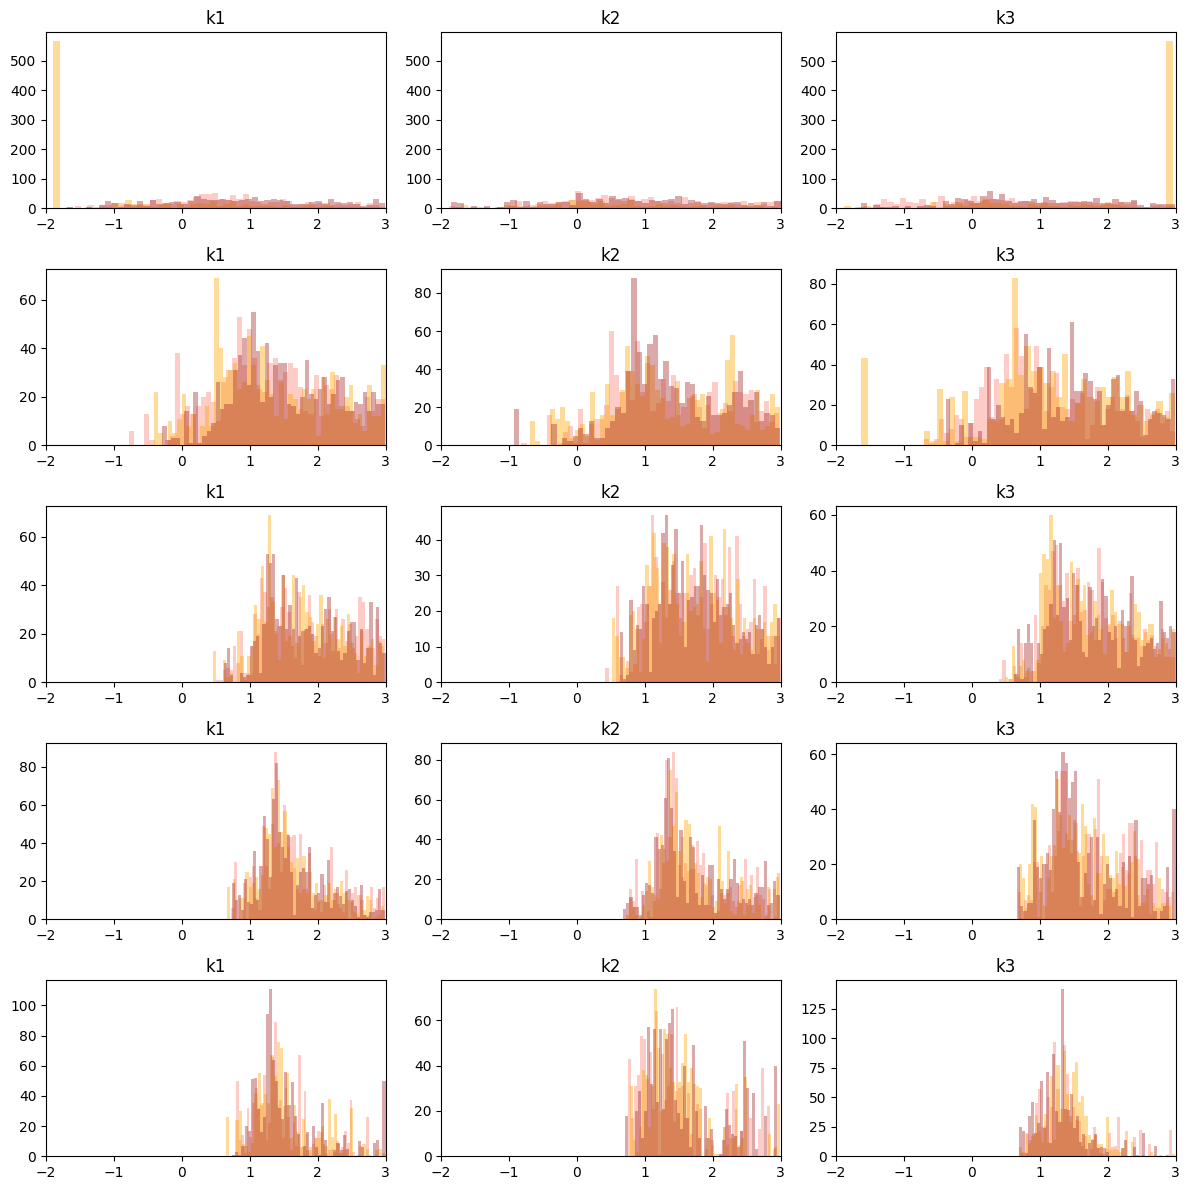

In [32]:
labels=["k1","k2","k3"]
fig, axs = plt.subplots(5,3,figsize=(12, 12))

for n in range(5):
    for p in range(0,3):
        for i in range(0,3):
            axs[n,p].hist(pa1[i][:,p][1000*(n):1000*(n+1)], alpha=.4, bins=50,color=col[i])

        axs[n,p].set_title(labels[p])
        axs[n,p].set_xlim(-2,3)
fig.tight_layout()

In [28]:
print(pa1[0].shape)
data=pd.DataFrame(pa1[0][-1000:])
print(data)

(5001, 3)
            0         1         2
0    2.268185  1.458781  1.624647
1    1.371055  1.585248  2.519183
2    1.371055  1.585248  2.519183
3    1.371055  1.585248  2.519183
4    1.371055  1.585248  2.519183
..        ...       ...       ...
995  1.155659  0.973504  1.208723
996  1.155659  0.973504  1.208723
997  1.155659  0.973504  1.208723
998  1.155659  0.973504  1.208723
999  1.155659  0.973504  1.208723

[1000 rows x 3 columns]


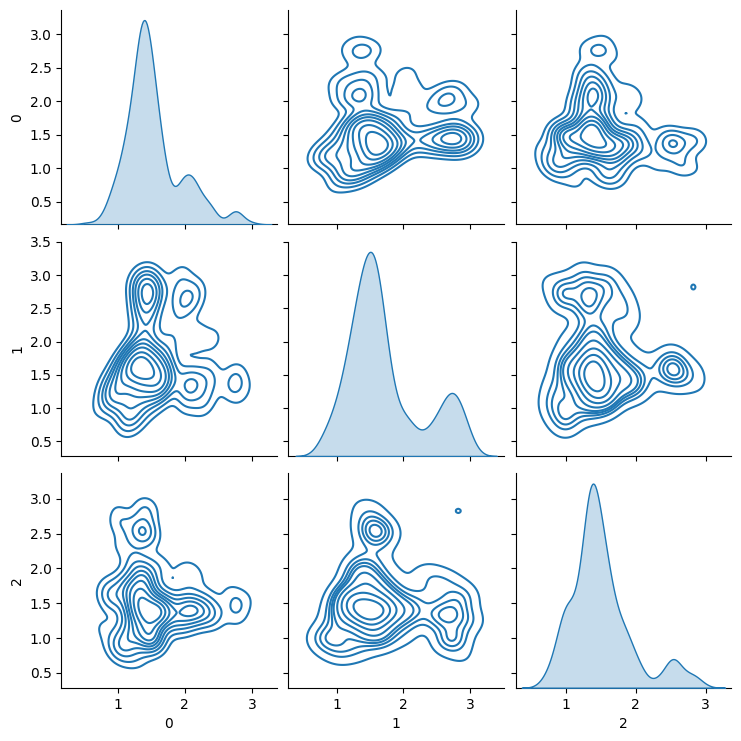

In [32]:
import pandas as pd
import seaborn as sns
plot_k = pd.DataFrame(data=np.array(pa1[0][-1000:,:])) #Just create a dataframe with rows corresponding to params
sns.pairplot(plot_k, kind="kde") #Just plot using a smoothing command (edited) 

In [16]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.0 MB/s eta 0:00:00a 0:00:01m


3.3840615658379116


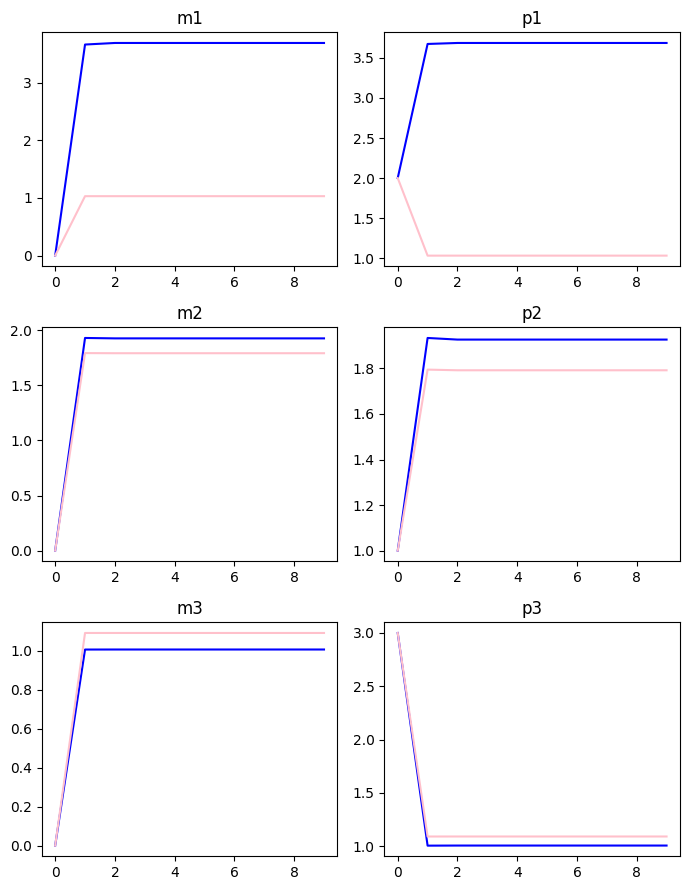

In [420]:
sol2=solve_ode([1,1.5,2])
sol1=solve_ode([2,1.5,2])
#sol2=solve_ode([2,1,1.5])
#sol4=solve_ode([1.5,2,1])
#sol4=solve_ode([-3,3,])
fig, ax=plt.subplots(3,2,figsize=(7,9))
ax = ax.ravel()
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    #ax[i].plot(sol3[:,i])
    #ax[i].plot(sol1[:,i], c="pink")
    ax[i].plot(sol2[:,i],c="blue")
    ax[i].plot(sol1[:,i],c="pink")
    ax[i].set_title(titles[i])
    

print(euclidean_distance_multiple_trajectories(sol1,sol2))
fig.tight_layout()

29.913635327198268


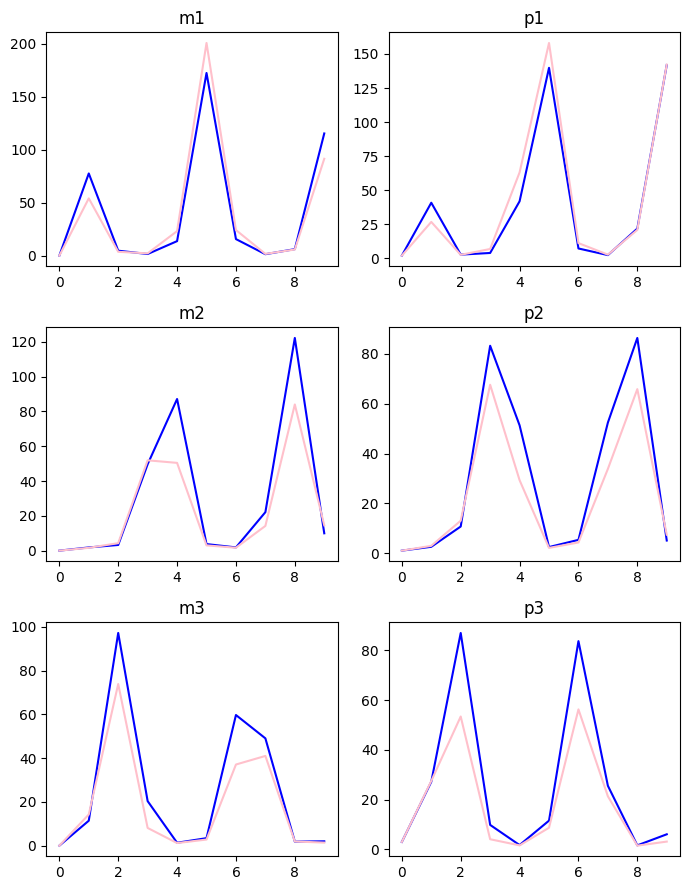

In [423]:
sol2=solve_ode([0,0,0])
sol1=solve_ode([0,0.2,0])
#sol2=solve_ode([2,1,1.5])
#sol4=solve_ode([1.5,2,1])
#sol4=solve_ode([-3,3,])
fig, ax=plt.subplots(3,2,figsize=(7,9))
ax = ax.ravel()
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    #ax[i].plot(sol3[:,i])
    #ax[i].plot(sol1[:,i], c="pink")
    ax[i].plot(sol2[:,i],c="blue")
    ax[i].plot(sol1[:,i],c="pink")
    ax[i].set_title(titles[i])

print(euclidean_distance_multiple_trajectories(sol1,sol2))
fig.tight_layout()

In [362]:
sol.

(10, 6)

In [248]:
len(pa1)

4

In [61]:
accepted_parameters, count, dis = mcmc_abc(true_params, 5000)

10th iterations done
20th iterations done
30th iterations done
40th iterations done
50th iterations done
60th iterations done
70th iterations done
80th iterations done
90th iterations done
100th iterations done
110th iterations done
120th iterations done
130th iterations done
140th iterations done
150th iterations done
160th iterations done
170th iterations done
180th iterations done
190th iterations done
200th iterations done
210th iterations done
220th iterations done
230th iterations done
240th iterations done
250th iterations done
260th iterations done
270th iterations done
280th iterations done
290th iterations done
300th iterations done
310th iterations done
320th iterations done
330th iterations done
340th iterations done
350th iterations done
360th iterations done
370th iterations done
380th iterations done
390th iterations done
400th iterations done
410th iterations done
420th iterations done
430th iterations done
440th iterations done
450th iterations done
460th iterations do

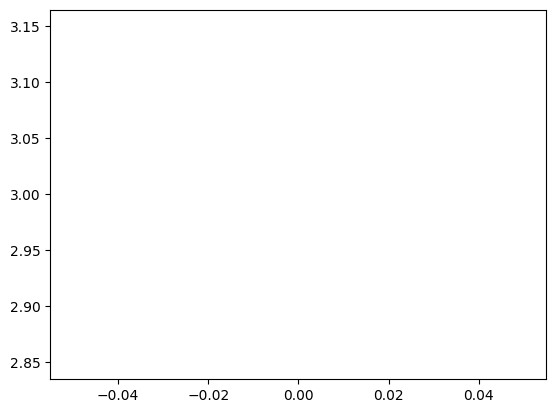

In [180]:
plt.boxplot(3,)

k2=accepted_parameters[:,2]
len(k2)

In [68]:
print(count)

1634


In [80]:
k2_ind=np.nonzero(k2)
k2_val=k2[k2_ind]

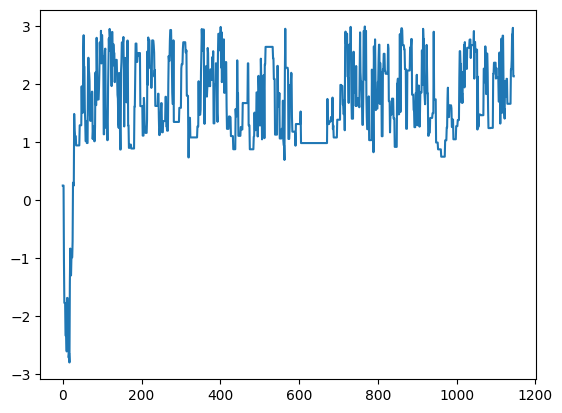

In [81]:
plt.plot(k2_val)

(array([  6.,   4.,   1.,   6.,  12., 160., 344., 274., 178., 161.]),
 array([-1.946738  , -1.45368071, -0.96062342, -0.46756613,  0.02549116,
         0.51854844,  1.01160573,  1.50466302,  1.99772031,  2.4907776 ,
         2.98383489]),
 <BarContainer object of 10 artists>)

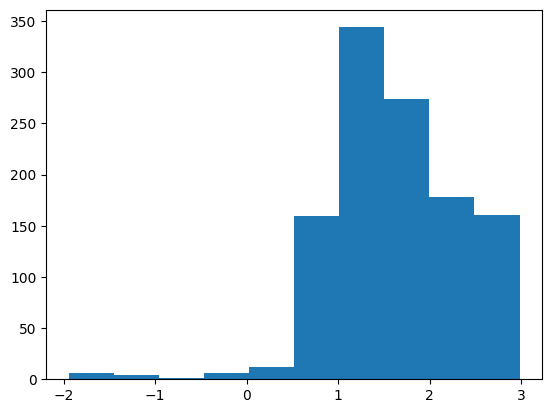

In [82]:
plt.hist(k1_val)

In [26]:
#triual

def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr=np.zeros(num_iterations+1)
    #accepted_data = np.zeros((num_iterations + 1, len(true_data)))
    count = 0
    count_lower_than_eps = 0

    # Initialized to random parameters
    sampled_params = loguniform.rvs(10**-3,10**3,size=12)
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    prior_prob = prior_pdf(sampled_params)
    for i in range(1, num_iterations + 1):
        if i % 10 == 0:
            print(f"{i}th iterations done")
        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(5) #maybe this is giving parameters that are out of bounds?
        new_sampled_params = np.clip(sampled_params + perturbation,10**-3,10**3) #clipping to ensure stays within bounds

        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)

        if distance < epsilon:
            prior_prob_new = prior_pdf(new_sampled_params)
            prob = min(1, prior_prob_new/prior_prob)
            count_lower_than_eps += 1
            if prob > np.random.uniform(0, 1):
                count += 1
                accepted_params[i] = sampled_params
                #accepted_data[i] = sampled_data
                prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params
        else:
            distance_arr[i]=distance
        
        

    return accepted_params[:count + 1], count, count_lower_than_eps, distance_arr

accepted_parameters, count, count_lower, dis = mcmc_abc(true_params, epsilon, 30)

10th iterations done lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1111111111111D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2222222222222D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2222222222222D+02
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will conti

/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_50228/997518711.py:18: RuntimeWarning: overflow encountered in scalar power
  dp3dt = -10 ** b[2] * (p[2] - m[2])


0000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2222222222222D+02
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1111111111111D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2222222222222D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2222222222222D+02
 lsoda--  warning.

In [27]:
print(dis)

[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [14]:
#trial no 2

def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = []
    accepted_data = []  # Added to store simulated data for accepted parameters
    count=0 #calculate acceptance rate
    count_lower_thaneps=0
   #initialised to random parameters
    sampled_params = 10**(np.random.uniform(-3,3,size=12))
    accepted_params.append(sampled_params)
    prior_prob=prior_pdf(sampled_params) #for now we only need priors cuz proprosal symetrical
    for i in range(num_iterations):
        if i%10==0:
            print(str(i)+"th iterations done")
        # using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(10)
        new_sampled_params = sampled_params + perturbation #new params = old params +perturbation
        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)
        if distance < epsilon:
            prior_prob_new=prior_pdf(new_sampled_params)
            prob=min(1, prior_prob_new/prior_prob)
            count_lower_thaneps+=1
            if prob>np.random.uniform(0,1):
                accepted_params.append(sampled_params)
                accepted_data.append(sampled_data)
                count+=1
                prior_prob=prior_prob_new #keep track of prior probs for efficiency
                sampled_params=new_sampled_params #
            
    return np.array(accepted_params), np.array(accepted_data), count, count_lower_thaneps


In [17]:
accepted_parameters, count, count_lower, dis = mcmc_abc(true_params, epsilon, 30)


0th iterations done
10th iterations done
20th iterations done


/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_50228/3598748024.py:4: RuntimeWarning: overflow encountered in square
  mean_squared_difference = np.mean(np.square(truth - simulation))


In [19]:
print(count)

[]


In [8]:
def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = []
    accepted_data = []  # Added to store simulated data for accepted parameters
    count=0 #calculate acceptance rate
    count_lower_thaneps=0
   #initialised to random parameters
    sampled_params = 10**(np.random.uniform(-3,3,size=12))
    accepted_params.append(sampled_params)
    prior_prob=prior_pdf(sampled_params) #for now we only need priors cuz proprosal symetrical
    for i in range(num_iterations):
        if i%10==0:
            print(str(i)+"th iterations done")
        # using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(1)
        new_sampled_params = sampled_params + perturbation #new params = old params +perturbation
        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)
        if distance < epsilon:
            prior_prob_new=prior_pdf(new_sampled_params)
            prob=min(1, prior_prob_new/prior_prob)
            count_lower_thaneps+=1
            if prob>np.random.uniform(0,1):
                accepted_params.append(sampled_params)
                accepted_data.append(sampled_data)
                count+=1
                prior_prob=prior_prob_new #keep track of prior probs for efficiency
                sampled_params=new_sampled_params #
            
    return np.array(accepted_params), np.array(accepted_data), count, count_lower_thaneps


# ABC rejection
#accepted_parameters, accepted_data = abc_rejection(true_params, epsilon, num_samples, num_timesteps)

In [9]:
accepted_parameters, accepted_data, count, count_lower = mcmc_abc(true_params, epsilon, 100)

What's the point of using mcmc if priors are uniformly distributed? hastings ratio = 1, always accept

In [ ]:
print(count)

In [7]:
def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    accepted_data = np.zeros((num_iterations + 1, len(true_data)))
    count = 0
    count_lower_than_eps = 0

    # Initialized to random parameters
    sampled_params = 10 ** (np.random.uniform(-3, 3, size=12))
    accepted_params[0] = sampled_params
    prior_prob = prior_pdf(sampled_params)

    for i in range(1, num_iterations + 1):
        if i % 10 == 0:
            print(f"{i}th iterations done")

        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(1)
        new_sampled_params = sampled_params + perturbation

        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)

        if distance < epsilon:
            prior_prob_new = prior_pdf(new_sampled_params)
            prob = min(1, prior_prob_new / prior_prob)
            count_lower_than_eps += 1

            if prob > np.random.uniform(0, 1):
                count += 1
                accepted_params[i] = sampled_params
                accepted_data[i] = sampled_data
                prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params

    return accepted_params[:count + 1], accepted_data[:count + 1], count, count_lower_than_eps

In [8]:
accepted_parameters, accepted_data, count, count_lower = mcmc_abc(true_params, epsilon, 100)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1111111111111D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2222222222222D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2222222222222D+00


/Users/E_V_/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_40151/3313981813.py:6: RuntimeWarning: invalid value encountered in log10
  return uniform.pdf(np.log10(params))


ValueError: could not broadcast input array from shape (10,6) into shape (10,)